# Lab 1 Part II: UCI-HAR 1D CNN

## Imports

In [1]:
from pathlib import Path
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Conv1D, MaxPool1D, Flatten, Dense, Activation
from keras.utils.data_utils import get_file
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt

2023-03-10 15:21:04.017819: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load and format UCI-HAR dataset (raw data)

In [2]:
dataset_path = get_file(None, "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip", extract=True, file_hash="53e099237392e0b9602f8c38f578bd8f") # Download, cache and extract UCI-HAR
dataset_dir = Path(dataset_path).parent

def load_set(dataset_dir, part: str): # Load separate sensor signals and combine them into a single array, load labels separately
    data = np.hstack([np.loadtxt(dataset_dir/'UCI HAR Dataset'/part/'Inertial Signals'/f'{sensor}_{axis}_{part}.txt')
                for sensor in ('body_acc', 'body_gyro', 'total_acc')
                    for axis in ('x', 'y', 'z')]).reshape((-1, 128, 9))
    labels = to_categorical(np.loadtxt(dataset_dir/'UCI HAR Dataset'/part/f'y_{part}.txt') - 1)
    return data, labels

x_train, y_train = load_set(dataset_dir, 'train')
x_test, y_test = load_set(dataset_dir, 'test')

60999314/60999314 [==============================] - 187s 3us/step


## Export complete test dataset (2947 vectors)

In [3]:
np.savetxt('x_test_uci-har.csv', x_test.reshape((x_test.shape[0], -1)), delimiter=',', fmt='%s')
np.savetxt('y_test_uci-har.csv', y_test, delimiter=',', fmt='%s')

## Export small test dataset (250 vectors)

In [4]:
x_test_250 = x_test[0:250]
y_test_250 = y_test[0:250]
np.savetxt('x_test_uci-har_250.csv', x_test_250.reshape((x_test_250.shape[0], -1)), delimiter=',', fmt='%s')
np.savetxt('y_test_uci-har_250.csv', y_test_250, delimiter=',', fmt='%s')

## Build model

In [5]:
model = Sequential()
model.add(Input(shape=(128, 9)))
model.add(Conv1D(filters=8, kernel_size=3, activation='relu'))
model.add(MaxPool1D())
model.add(Conv1D(filters=8, kernel_size=5, activation='relu'))
model.add(MaxPool1D())
model.add(Conv1D(filters=8, kernel_size=7, activation='relu'))
model.add(Flatten())
model.add(Dense(units=6))
model.add(Activation('softmax')) # SoftMax activation needs to be separate from Dense to remove it later on
# EXPLORE Learning Rate
opt = tf.keras.optimizers.Adam(learning_rate=10e-3)
model.summary()
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 126, 8)            224       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 63, 8)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 59, 8)             328       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 29, 8)            0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 23, 8)             456       
                                                                 
 flatten (Flatten)           (None, 184)               0

2023-03-10 15:24:18.583945: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Train model

Epoch 1/7
230/230 [==============================] - 2s 5ms/step - loss: 0.4288 - categorical_accuracy: 0.8278 - val_loss: 0.3458 - val_categorical_accuracy: 0.8775
Epoch 2/7
230/230 [==============================] - 1s 4ms/step - loss: 0.1739 - categorical_accuracy: 0.9334 - val_loss: 0.3335 - val_categorical_accuracy: 0.9026
Epoch 3/7
230/230 [==============================] - 1s 4ms/step - loss: 0.1475 - categorical_accuracy: 0.9459 - val_loss: 0.2292 - val_categorical_accuracy: 0.9233
Epoch 4/7
230/230 [==============================] - 1s 4ms/step - loss: 0.1307 - categorical_accuracy: 0.9490 - val_loss: 0.3397 - val_categorical_accuracy: 0.9118
Epoch 5/7
230/230 [==============================] - 1s 4ms/step - loss: 0.1130 - categorical_accuracy: 0.9578 - val_loss: 0.4307 - val_categorical_accuracy: 0.9067
Epoch 6/7
230/230 [==============================] - 1s 4ms/step - loss: 0.1150 - categorical_accuracy: 0.9584 - val_loss: 0.3716 - val_categorical_accuracy: 0.9006
Epoch 7/7


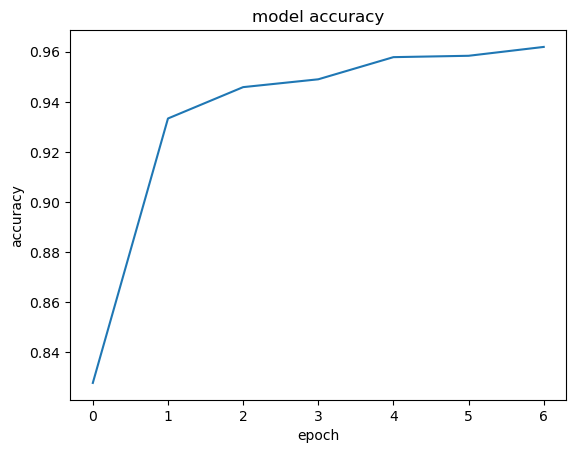

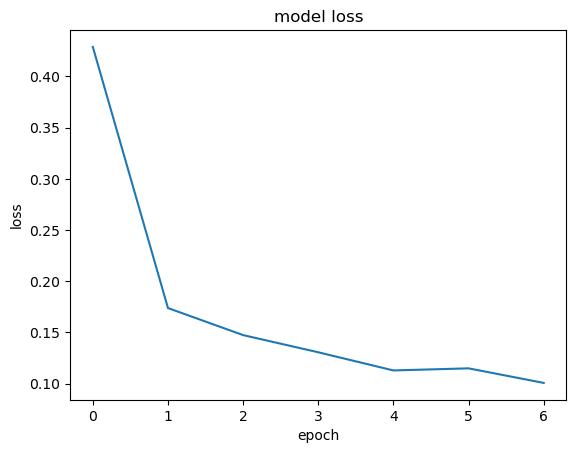

In [6]:
history = model.fit(x_train, y_train, epochs=7, validation_data=(x_test, y_test))

plt.plot(history.history['categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()


plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

## Evaluate model on complete test dataset

In [7]:
model.evaluate(x_test, y_test, verbose=2)
pred_test = model.predict(x_test)
print(tf.math.confusion_matrix(y_test.argmax(axis=1), pred_test.argmax(axis=1)))

93/93 - 0s - loss: 0.3370 - categorical_accuracy: 0.9274 - 148ms/epoch - 2ms/step
93/93 [==============================] - 0s 2ms/step
tf.Tensor(
[[477   5  13   0   1   0]
 [  8 439  22   1   1   0]
 [ 10  28 382   0   0   0]
 [  0   1   0 404  65  21]
 [  1   2   0  34 495   0]
 [  0   0   0   1   0 536]], shape=(6, 6), dtype=int32)


## Evaluate model on small test dataset

In [8]:
model.evaluate(x_test_250, y_test_250, verbose=2)
pred_test_250 = model.predict(x_test_250)
print(tf.math.confusion_matrix(y_test_250.argmax(axis=1), pred_test_250.argmax(axis=1)))

8/8 - 0s - loss: 0.3110 - categorical_accuracy: 0.9160 - 30ms/epoch - 4ms/step
8/8 [==============================] - 0s 2ms/step
tf.Tensor(
[[51  2  0  0  0  0]
 [ 0 24  0  0  1  0]
 [ 0  5 19  0  0  0]
 [ 0  0  0 33 13  0]
 [ 0  0  0  0 54  0]
 [ 0  0  0  0  0 48]], shape=(6, 6), dtype=int32)


## Save trained model

In [9]:
model.save('lab1_part2_uci-har.h5')